In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type)!= 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
sales_train_validation_data = pd.read_csv(r'C:\Users\mahendra\Desktop\analytics\projects\M5_Forecasting_Accuracy_kaggle/sales_train_validation.csv')
sales_train_validation_data = reduce_mem_usage(sales_train_validation_data)
calendar_data = pd.read_csv(r'C:\Users\mahendra\Desktop\analytics\projects\M5_Forecasting_Accuracy_kaggle/calendar.csv')
calendar_data = reduce_mem_usage(calendar_data)
prices_data = pd.read_csv(r'C:\Users\mahendra\Desktop\analytics\projects\M5_Forecasting_Accuracy_kaggle/sell_prices.csv')
prices_data = reduce_mem_usage(prices_data)

Memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.42 MB
Decreased by 78.6%
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.22 MB
Decreased by -5.7%
Memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 45.77 MB
Decreased by 78.1%


In [4]:
sales_train_evaluation_data = pd.read_csv(r'C:\Users\mahendra\Desktop\analytics\projects\M5 Forecasting_Accuracy_kaggle/sales_train_evaluation.csv')
sample_submission_data = pd.read_csv(r'C:\Users\mahendra\Desktop\analytics\projects\M5 Forecasting_Accuracy_kaggle/sample_submission.csv')

In [5]:
sales_train_evaluation_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


# preprocessing 

In [6]:
# doing this to generate test data for 28 days (d_1914 to d_1941)
for i in range(1914, 1942):
    sales_train_validation_data['d_'+str(i)] = np.nan

In [7]:
d_colnames = []
for i in range(1, 1942):
    d_colnames.append('d_'+str(i))

In [8]:
sales_train_validation_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
sales_train_validation_data_new = pd.melt(sales_train_validation_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        value_vars=d_colnames, var_name='day_number', value_name='units_sold')

In [10]:
sales_train_validation_data_new['day_number']=sales_train_validation_data_new['day_number'].apply(lambda x: int(x[2:]))

In [11]:
sales_train_validation_data_new = reduce_mem_usage(sales_train_validation_data_new)

Memory usage of dataframe is 1356.13 MB
Memory usage after optimization is: 678.86 MB
Decreased by 49.9%


In [12]:
sales_train_validation_data_new.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0


In [13]:
calendar_data['d']=calendar_data['d'].apply(lambda x: int(x[2:]))

In [14]:
merge_data=sales_train_validation_data_new.merge(calendar_data,left_on='day_number',right_on='d',how='left')

In [15]:
merge_data = reduce_mem_usage(merge_data)

Memory usage of dataframe is 2485.11 MB
Memory usage after optimization is: 2146.57 MB
Decreased by 13.6%


In [16]:
merge_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,wm_yr_wk,...,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,1,2011,1,NaN,NaN,NaN,NaN,0,0,0


In [17]:
prices_data.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [18]:
merge=merge_data.merge(prices_data,left_on=['store_id','item_id','wm_yr_wk'],
                      right_on=['store_id','item_id','wm_yr_wk'],how='left')

In [19]:
merge=reduce_mem_usage(merge)

Memory usage of dataframe is 2259.45 MB
Memory usage after optimization is: 2259.45 MB
Decreased by 0.0%


In [20]:
merge.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,wm_yr_wk,...,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,11101,...,2011,1,NaN,NaN,NaN,NaN,0,0,0,NaN


In [21]:
merge.drop(['wday', 'd', 'wm_yr_wk'], inplace=True, axis=1)

In [22]:
merge['date']=pd.to_datetime(merge['date'])
merge['week']=merge['date'].dt.week

In [23]:
merge.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0.0,2011-01-29,Saturday,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,4



# Data Visualization

In [31]:
# avg daily units sold per dept
avg_dept_sales_days = merge[['dept_id', 'day_number', 'units_sold']] \
                            .groupby('dept_id') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()

In [34]:
avg_dept_sales_days.columns=['dept_id','avg_sales']

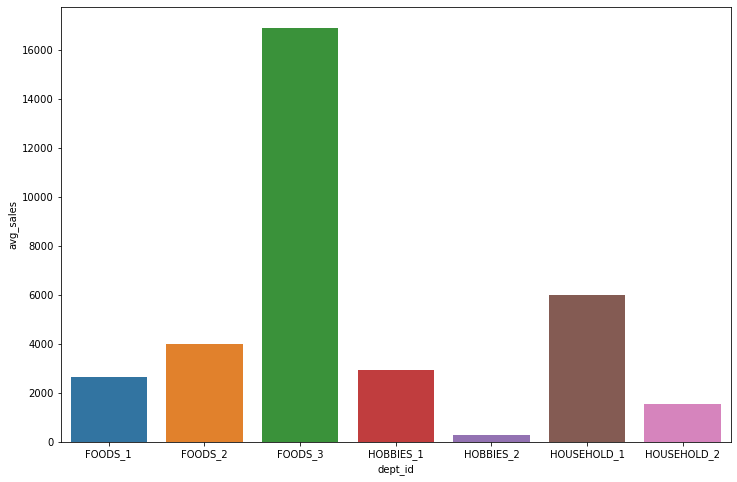

In [36]:
figure = plt.figure(figsize=(12,8))
sns.barplot(x='dept_id',y='avg_sales',data=avg_dept_sales_days)

In [42]:
# avg daily units sold per store
avg_store_sales_days = merge[['store_id', 'day_number', 'units_sold']] \
                            .groupby('store_id') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()
avg_store_sales_days.columns=['store_id','avg_sales']

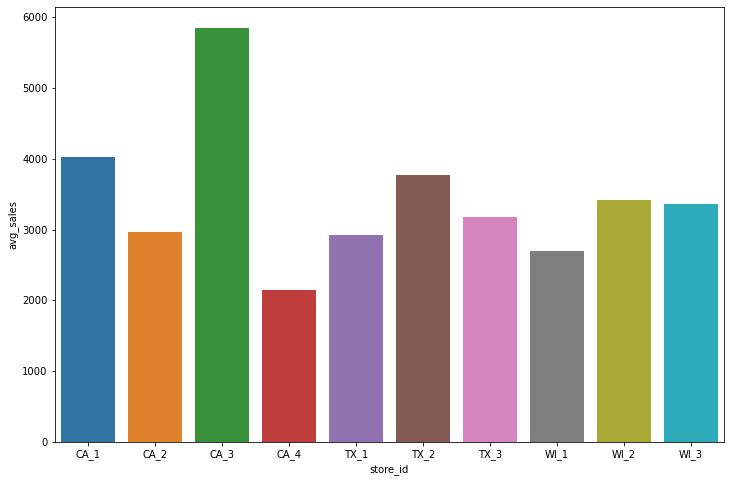

In [43]:
figure = plt.figure(figsize=(12,8))
sns.barplot(x='store_id',y='avg_sales',data=avg_store_sales_days)

In [44]:
#avg daily units sold per store
avg_weekday_sales_days = merge[['weekday', 'day_number', 'units_sold']] \
                            .groupby('weekday') \
                            .apply(lambda x: x['units_sold'].sum() / x['day_number'].nunique()).reset_index()
avg_weekday_sales_days.columns=['weekday','avg_sales']

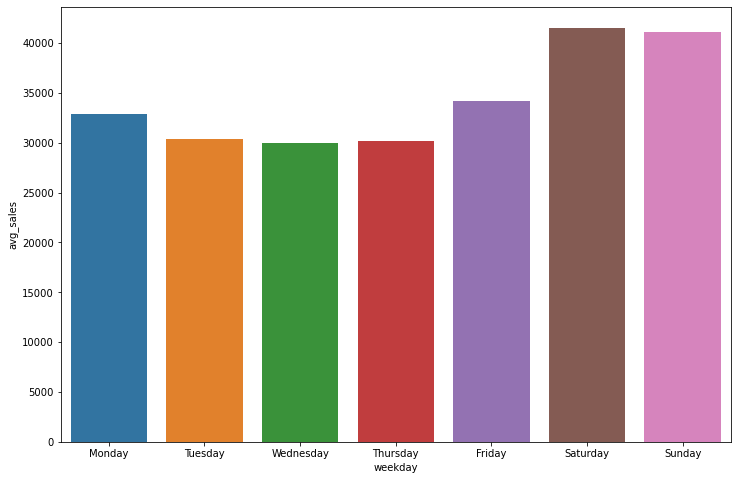

In [46]:
figure = plt.figure(figsize=(12,8))
sns.barplot(x='weekday',y='avg_sales',data=avg_weekday_sales_days,order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

In [50]:
#avg daily units sold day number
# rolling mean of total daily units sold per day for 1913 days 
total_daily_sales = merge[['day_number', 'units_sold']].groupby('day_number').sum().reset_index()
# rename columns
total_daily_sales.columns = ['day', 'total_units_sold']
total_daily_sales['total_units_sold_rolling_mean']=total_daily_sales['total_units_sold'].rolling(50, min_periods=1).mean()

In [52]:
total_daily_sales=pd.DataFrame(total_daily_sales)

Text(0, 0.5, 'Rolling mean of units sold')

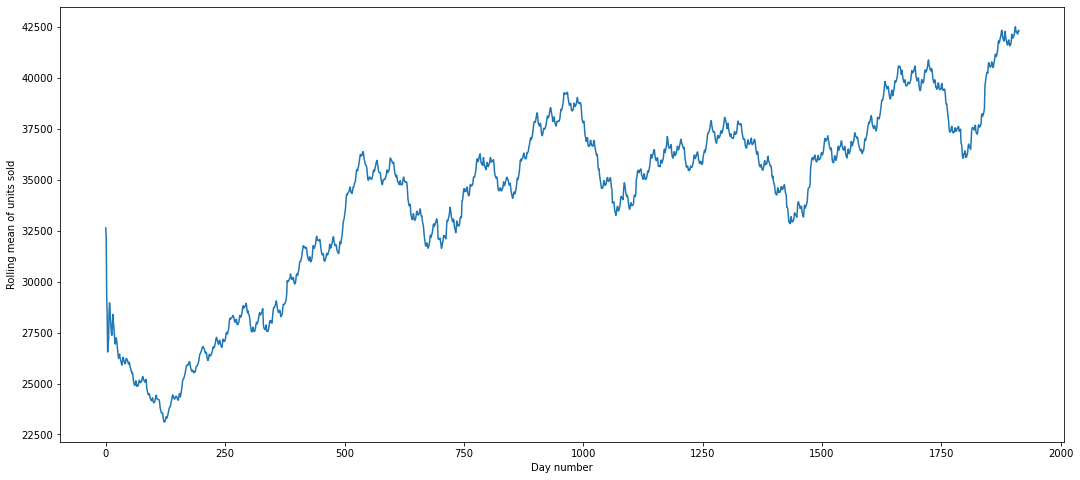

In [53]:
# plot time series
figure = plt.figure(figsize=(18,8))
plt.plot(total_daily_sales.iloc[:, 0], total_daily_sales.iloc[:,2])
plt.xlabel('Day number')
plt.ylabel('Rolling mean of units sold')

In [54]:
#avg daily units sold date 
total_daily_sales = merge[['date', 'units_sold']].groupby('date').sum().reset_index()
# rename columns
total_daily_sales.columns = ['date', 'total_units_sold']
total_daily_sales['total_units_sold_rolling_mean']=total_daily_sales['total_units_sold'].rolling(50, min_periods=1).mean()

Text(0, 0.5, 'Rolling mean of units sold')

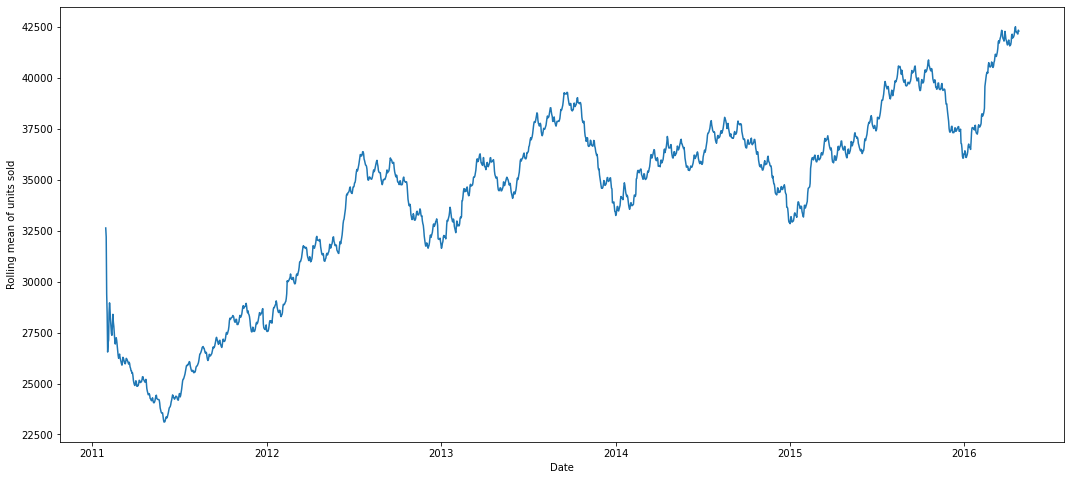

In [57]:
# plot time series
figure = plt.figure(figsize=(18,8))
plt.plot(total_daily_sales.iloc[:, 0], total_daily_sales.iloc[:,2])
plt.xlabel('Date')
plt.ylabel('Rolling mean of units sold')

# PCA and K-means clustering

In [58]:
d_colnames
daily_sales_per_product = sales_train_validation_data[['item_id']+ d_colnames] \
                    .groupby('item_id').sum().reset_index()

In [60]:
daily_sales_per_product.head()

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_001,6,6,4,6,7,18,10,4,11,...,4,4,30,7.0,5.0,3.0,6.0,2,16,6
1,FOODS_1_002,4,5,7,4,3,4,1,7,2,...,5,9,4,1.0,3.0,5.0,5.0,3,3,1
2,FOODS_1_003,14,8,3,6,3,8,13,10,11,...,7,3,5,6.0,3.0,4.0,4.0,3,11,5
3,FOODS_1_004,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0
4,FOODS_1_005,34,32,13,20,10,21,18,20,25,...,16,14,14,18.0,18.0,27.0,12.0,15,38,9


In [61]:
pca=PCA(n_components=50)
pca.fit(daily_sales_per_product.iloc[:,1:])

PCA(n_components=50)

In [65]:
pca_transform_data=pca.transform(daily_sales_per_product.iloc[:,1:])

In [66]:
kmeans = KMeans(n_clusters=50, random_state=0).fit(pca_transform_data)
daily_sales_per_product['cluster']=kmeans.labels_

In [24]:
# We assume that the first 1000 days of data will not be relevant to forecast future sales since 
# this data is very old
merge_df = merge[merge.day_number.astype(int) > 972]
len(merge_df)

29544810

In [25]:
unique_dept_ids = merge_df.dept_id.unique().to_list()

In [26]:
unique_dept_ids

['HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2',
 'FOODS_1',
 'FOODS_2',
 'FOODS_3']

In [27]:
merge_df['event_type_1'] = merge_df['event_type_1'].cat.add_categories('Unknown')
merge_df['event_type_2'] = merge_df['event_type_2'].cat.add_categories('Unknown')
merge_df['event_name_1'] = merge_df['event_name_1'].cat.add_categories('Unknown')
merge_df['event_name_2'] = merge_df['event_name_2'].cat.add_categories('Unknown')

merge_df['event_type_1'].fillna('Unknown', inplace=True)
merge_df['event_type_2'].fillna('Unknown', inplace=True)
merge_df['event_name_1'].fillna('Unknown', inplace=True)
merge_df['event_name_2'].fillna('Unknown', inplace=True)

C:\Users\mahendra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mahendra\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mahendra\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [28]:
#Label encoding
leitem_id = preprocessing.LabelEncoder()
leitem_id.fit(merge_df.item_id)

lestore_id = preprocessing.LabelEncoder()
lestore_id.fit(merge_df.store_id)

leweekday = preprocessing.LabelEncoder()
leweekday.fit(merge_df.weekday)

leevent_type_1 = preprocessing.LabelEncoder()
leevent_type_1.fit(merge_df.event_type_1)

leevent_type_2 = preprocessing.LabelEncoder()
leevent_type_2.fit(merge_df.event_type_2)

leevent_name_1 = preprocessing.LabelEncoder()
leevent_name_1.fit(merge_df.event_name_1)

leevent_name_2 = preprocessing.LabelEncoder()
leevent_name_2.fit(merge_df.event_name_2)

LabelEncoder()

In [29]:
#we don't really care about the corresponding state values for other states for that row
def snap(row):
    if row['snap_'+ row.state_id] == 1:
        return 1
    return 0

In [30]:
def dept_feature_generation(deptid):
    dept_data = merge_df.loc[merge_df.dept_id == deptid].copy()
    dept_data['snap'] = dept_data.apply(snap, axis=1)
    dept_data.drop(['snap_CA', 'snap_WI', 'snap_TX'], axis=1, inplace=True)
    
    dept_data.drop(['cat_id', 'state_id', 'date', 'year'], axis=1, inplace=True)
    dept_data['units_lag_28'] = dept_data.groupby('id')['units_sold'].transform(
        lambda x: x.shift(28, fill_value=0)
    )
    
    print('Starting column generation....')

    # https://pbpython.com/pandas_transform.html
    # Rolling units sold for days -28 to -34
    dept_data['mean_rolling_7'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    # Rolling units sold for days -28 to -55
    dept_data['mean_rolling_28'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(28, min_periods=1).mean())
    
    
    # Rolling units sold for days -28 to -76
    dept_data['mean_rolling_49'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(49, min_periods=1).mean())
    dept_data['mean_rolling_84'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(84, min_periods=1).mean())
    dept_data['mean_rolling_140'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(140, min_periods=1).mean())
    
    
    dept_data['std_rolling_7'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(7, min_periods=1).std())
    dept_data['std_rolling_28'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(28, min_periods=1).std())
    dept_data['std_rolling_49'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(49, min_periods=1).std())
    dept_data['std_rolling_84'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(84, min_periods=1).std())
    dept_data['std_rolling_140'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(140, min_periods=1).std())
    
    
    dept_data['std_price_rolling_7'] = dept_data.groupby('id')['sell_price'].transform(
        lambda x: x.rolling(7, min_periods=1).std())
    dept_data['std_price_rolling_28'] = dept_data.groupby('id')['sell_price'].transform(
        lambda x: x.rolling(28, min_periods=1).std())
    dept_data['price_percent_change'] = dept_data.groupby('id')['sell_price'].pct_change()
    
    dept_data.drop('id', axis=1, inplace=True)
    dept_data.reset_index(drop=True, inplace=True)
    
    dept_data['item_id'] = leitem_id.transform(dept_data.item_id)
    dept_data['store_id'] = lestore_id.transform(dept_data['store_id'])
    dept_data['weekday'] =  leweekday.transform(dept_data['weekday'])
    dept_data['event_name_1'] = leevent_name_1.transform(dept_data['event_name_1'])
    dept_data['event_name_2'] = leevent_name_2.transform(dept_data['event_name_2'])
    dept_data['event_type_1'] = leevent_type_1.transform(dept_data['event_type_1'])
    dept_data['event_type_2'] = leevent_type_2.transform(dept_data['event_type_2'])
    
    # Keep only non-zero rolling value rows
    dept_data = dept_data[dept_data.day_number.astype(int) > 1000]
    
    return dept_data

In [31]:
column_order = []
for i in range(1,29):
    column_order.append('F'+str(i))

In [32]:
unique_dept_ids

['HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2',
 'FOODS_1',
 'FOODS_2',
 'FOODS_3']

In [41]:
feature_data=dept_feature_generation('HOBBIES_2')

Starting column generation....


In [42]:
indices_list = [2]
for i in range(5, feature_data.shape[1]):
    indices_list.append(i)

In [43]:
feature_data_train = feature_data[feature_data.day_number.astype(int) <= 1885].reset_index(drop=True)
feature_data_validation = feature_data[(feature_data.day_number.astype(int) > 1885)
                                         & (feature_data.day_number.astype(int) < 1914)].reset_index(drop=True)
feature_data_test = feature_data[feature_data.day_number.astype(int) >= 1914].reset_index(drop=True)

feature_data_train_x = feature_data_train.iloc[:, indices_list]
feature_data_train_y = feature_data_train.units_sold
feature_data_validation_x = feature_data_validation.iloc[:, indices_list]
feature_data_validation_y = feature_data_validation.units_sold

feature_data_test_x = feature_data_test.iloc[:, indices_list]

In [44]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
model.fit(feature_data_train_x,feature_data_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [45]:
xgb_pred=np.round(model.predict(feature_data_validation_x))

In [46]:
np.sqrt(mean_squared_error(feature_data_validation_y.values, xgb_pred))

0.7940031

# XGB_MODEL

In [55]:
merged_df = None
for dept in unique_dept_ids:
    feature_data=dept_feature_generation(dept)
    indices_list = [2]
    for i in range(5, feature_data.shape[1]):
        indices_list.append(i)
    feature_data_train = feature_data[feature_data.day_number.astype(int) < 1914].reset_index(drop=True) 
    feature_data_test = feature_data[feature_data.day_number.astype(int) >= 1914].reset_index(drop=True)
    feature_data_train_x = feature_data_train.iloc[:, indices_list]
    feature_data_train_y = feature_data_train.units_sold
    feature_data_test_x = feature_data_test.iloc[:, indices_list]
    model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
    model.fit(feature_data_train_x, feature_data_train_y)
    xgb_preds = np.round(model.predict(feature_data_test_x))
    df= feature_data_test[['item_id', 'store_id', 'day_number']].copy()
    df['units_sold'] = xgb_preds
    
    df['item_id'] = leitem_id.inverse_transform(df.item_id)
    df['store_id'] = lestore_id.inverse_transform(df.store_id)

    df['day_number'] = df['day_number'].astype(np.int16) - 1913
    df['day_number'] = 'F'+ df['day_number'].astype(str)

    df['id'] = df['item_id']+'_'+df['store_id']+'_validation'
    df = df.pivot(index='id', columns='day_number', values=['units_sold'])
    df.reset_index()
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df=pd.DataFrame(df)
    df = df.rename_axis(None, axis=1)
    df = df[['id'] + column_order]
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.concat([merged_df, df])
    

Starting column generation....
Starting column generation....
Starting column generation....
[19:06:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Starting column generation....
[19:25:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Starting column generation....
Starting column generation....
Starting column generation....
[20:14:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_m

In [56]:
merged_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,HOBBIES_1_001_CA_2_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,HOBBIES_1_001_CA_3_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,HOBBIES_1_001_CA_4_validation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,HOBBIES_1_001_TX_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8225,FOODS_3_827_TX_2_validation,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0
8226,FOODS_3_827_TX_3_validation,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
8227,FOODS_3_827_WI_1_validation,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,...,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0
8228,FOODS_3_827_WI_2_validation,2.0,2.0,2.0,2.0,3.0,3.0,4.0,3.0,3.0,...,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0


In [57]:
merged_df_2 = merged_df.copy()

In [58]:
merged_df_2['id'] = merged_df_2['id'].apply(
    lambda x: x.replace('validation', 'evaluation'))

In [60]:
merged_df3 = pd.concat([merged_df, merged_df_2])

In [62]:
merged_df3.to_csv('xgboost_predictions.csv', index=False)

# LGB_MODEL

In [ ]:
merged_df = None
for dept in unique_dept_ids:
    feature_data=dept_feature_generation(dept)
    indices_list = [2]
    for i in range(5, feature_data.shape[1]):
        indices_list.append(i)
    feature_data_train = feature_data[feature_data.day_number.astype(int) < 1914].reset_index(drop=True) 
    feature_data_test = feature_data[feature_data.day_number.astype(int) >= 1914].reset_index(drop=True)
    feature_data_train_x = feature_data_train.iloc[:, indices_list]
    feature_data_train_y = feature_data_train.units_sold
    feature_data_test_x = feature_data_test.iloc[:, indices_list]
    model = lgb.LGBMRegressor(colsample_bytree=0.4,                 
                 learning_rate=0.1,
                 max_depth=6,
                 n_estimators=200)
    model.fit(feature_data_train_x, feature_data_train_y)
    xgb_preds = np.round(model.predict(feature_data_test_x))
    df= feature_data_test[['item_id', 'store_id', 'day_number']].copy()
    df['units_sold'] = xgb_preds
    
    df['item_id'] = leitem_id.inverse_transform(df.item_id)
    df['store_id'] = lestore_id.inverse_transform(df.store_id)

    df['day_number'] = df['day_number'].astype(np.int16) - 1913
    df['day_number'] = 'F'+ df['day_number'].astype(str)

    df['id'] = df['item_id']+'_'+df['store_id']+'_validation'
    df = df.pivot(index='id', columns='day_number', values=['units_sold'])
    df.reset_index()
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df=pd.DataFrame(df)
    df = df.rename_axis(None, axis=1)
    df = df[['id'] + column_order]
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.concat([merged_df, df])


Starting column generation....
Starting column generation....
Starting column generation....
Starting column generation....
Starting column generation....


In [ ]:
merged_df_2 = merged_df.copy()
merged_df_2['id'] = merged_df_2['id'].apply(
    lambda x: x.replace('validation', 'evaluation'))

In [ ]:
merged_df3 = pd.concat([merged_df, merged_df_2])

In [ ]:
merged_df3.to_csv('lgboost_predictions.csv', index=False)

# Voting 

In [38]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=800, max_depth=15, oob_score=True, n_jobs=6, random_state=123, min_samples_split=10, min_samples_leaf=10)

In [39]:
xgb = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [40]:
lgb = lgb.LGBMRegressor(colsample_bytree=0.4,                 
                 learning_rate=0.1,
                 max_depth=6,
                 n_estimators=200)

In [42]:
from sklearn.ensemble import VotingRegressor
estim=[('regr',regr),('xgb',xgb),('lgb',lgb)]

In [43]:
VotingRegressor(estimators=estim)

VotingRegressor(estimators=[('regr',
                             RandomForestRegressor(max_depth=15,
                                                   min_samples_leaf=10,
                                                   min_samples_split=10,
                                                   n_estimators=800, n_jobs=6,
                                                   oob_score=True,
                                                   random_state=123)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.4, gamma=0,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constrai...
                                          max_delta_step=None, max_depth=3,
  

In [44]:
merged_df = None
for dept in unique_dept_ids:
    feature_data=dept_feature_generation(dept)
    indices_list = [2]
    for i in range(5, feature_data.shape[1]):
        indices_list.append(i)
    feature_data_train = feature_data[feature_data.day_number.astype(int) < 1914].reset_index(drop=True) 
    feature_data_test = feature_data[feature_data.day_number.astype(int) >= 1914].reset_index(drop=True)
    feature_data_train_x = feature_data_train.iloc[:, indices_list]
    feature_data_train_y = feature_data_train.units_sold
    feature_data_test_x = feature_data_test.iloc[:, indices_list]
    model = VotingRegressor(estimators=estim)
    model.fit(feature_data_train_x, feature_data_train_y)
    xgb_preds = np.round(model.predict(feature_data_test_x))
    df= feature_data_test[['item_id', 'store_id', 'day_number']].copy()
    df['units_sold'] = xgb_preds
    
    df['item_id'] = leitem_id.inverse_transform(df.item_id)
    df['store_id'] = lestore_id.inverse_transform(df.store_id)

    df['day_number'] = df['day_number'].astype(np.int16) - 1913
    df['day_number'] = 'F'+ df['day_number'].astype(str)

    df['id'] = df['item_id']+'_'+df['store_id']+'_validation'
    df = df.pivot(index='id', columns='day_number', values=['units_sold'])
    df.reset_index()
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df=pd.DataFrame(df)
    df = df.rename_axis(None, axis=1)
    df = df[['id'] + column_order]
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.concat([merged_df, df])

Starting column generation....


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').